# Import Declarations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

# Constant Declarations

In [ ]:
NUMBER_OF_WEIGHTS = 3

# Convert the classifiers into numbers for arrays
APARTMENT = 0
CONDO = 1
HOUSE = 2

# Convert the confusion matrix into numbers for indexing
TP = 0
TN = 1
FP = 2
FN = 3

# Math Constants. Wasn't sure how far "external libraries" extended, but
# I don't want to risk it by including the math module.
e = 2.718281828459
pi = 3.141592653589

# Main Function

In [ ]:
def main():
  print("Linear Regression:")
  linearRegression()

  print("\nNaive Bayes:")
  naiveBayes()

  print("\nK Means:")
  kValue = int(input("What value for K do you want?: "))
  kMeans(kValue)

# Problem Functions (linear regression)

In [ ]:
# We have only one variable so we'll have the equation: y = θ1 + θ2 * x
# since this is slope-intercept form, we'll just use y = b + mx
def linearRegression():
  # Load in the data from the input files
  x_train, y_train, x_test, y_test = readInTrainTestData()

  # Initialize random values for all of the weights
  weights = initializeValues(NUMBER_OF_WEIGHTS)

  oldWeights = None

  # Repeat this loop until the weights converge
  while (np.array_equal(weights, oldWeights) == False):

      # Keep track of updates and do one iteration of batch gradient descent.
      oldWeights = np.copy(weights)
      weights = gradientDescentUpdate(weights, x_train, y_train)

  printEquation(weights)

  # Print out the MSE for the test values against our model
  print("MSE: ", end="")
  print(meanSquaredError(x_test, y_test, weights))

  plotModelAgainstData(x_test, y_test, weights)

  return

# Supporting Functions For Linear Regression

In [ ]:
def readInTrainTestData():
  # We'll assumed that the data is located here.
  x_train = np.load("x_train.npy")
  y_train = np.load("y_train.npy")

  x_test = np.load("x_test.npy")
  y_test = np.load("y_test.npy")

  return x_train, y_train, x_test, y_test

In [ ]:
def plotModelAgainstData(x_values, y_values, weights):

  # Clear the plot, plot the current values, calculate the values from
  # our hypothesis function, then plot those over the real points.
  plt.clf()
  plt.subplot(211)
  plt.scatter(x_values, y_values)
  y_estimates = []
  for i in range(x_values.size):
    y_estimates.append(hypothesisFunction(weights, x_values[i][0]))
  y_estimates = np.array(y_estimates)
  plt.scatter(x_values, y_estimates)

In [ ]:
# Returns an np array with dimensions 1xnum that contains num random
# weights from 0 (inclusive) to 1 (exclusive).
def initializeValues(num):
  return np.random.default_rng().uniform(0, 1, num)

In [ ]:
# In order to calculate how well different models fit the the test data, we use MSE.
# MSE = 1/n * Ε for all j ((y - y hat)^2)
def meanSquaredError(x_values, y_values, weights):
  error = 0

  for i in range(x_values.size):
    # The hypothesis function is our y hat.
    error += (y_values[i] - hypothesisFunction(weights, x_values[i][0]))**2

  error /= x_values.size
  return error

In [ ]:
# We'll define the hypothesis function as:
# y = ϴ0 + ϴ1 * x + ϴ2 * x^2 + ... + ϴn * x^n
# This helps gives us some non-linearity to our model
def hypothesisFunction(weights, x):
  result = 0

  # With the definition of the hypothesis function above, we're
  # able to do this simple loop since x^0 = 1. Lucky!
  for i in range(weights.size):
    result += weights[i] * x**i

  return result

In [ ]:
# Use batch gradient descent
def gradientDescentUpdate(weights, x_train, y_train):
  # To stop from having to update the learning rate for every number of weights,
  # we'll define it based on some small value that'll get smaller with more weights.
  learningRate = 0.001 / (NUMBER_OF_WEIGHTS**2)

  newWeights = []

  # Update each weight using batch gradient descent
  for i in range(weights.size):
    error = 0

    # In batch gradient descent, we need to find the sum of all the errors.
    for j in range(x_train.size):
      x_value = x_train[j][0]

      error += (y_train[j] - hypothesisFunction(weights, x_value)) * x_value**i

    # ϴ = ϴ + a * error
    newWeight = weights[i] + learningRate * error

    # Keep track of the weights without updating. Adjusting them immediately
    # will mess up the calculations for all of the following weights
    newWeights.append(newWeight)

# Adjust the weights now that the updates have been found
  for i in range(weights.size):
    weights[i] = newWeights[i]

  return weights

In [ ]:
def printEquation(weights):
  if len(weights) == 0:
    return

  print(f'y = {weights[0]}', end='')

  for i in range(1, len(weights)):
    print(f' + {weights[i]} * x^{i}', end='')
  print()

  return

# Problem Function (Naive Bayes)

In [ ]:
def naiveBayes():

  # Load the probabilities that I calculated.
  localPriceProbabilities, bathroomProbabilities, landAreaProbabilities,\
    livingAreaProbabiltiies, numGaragesProbabilities, numRoomsProbabilities,\
    numBedroomsProbabilities, ageOfHomeProbabilities, constructionTypeProbabilities = loadProbabilities()

  f = pd.read_excel("Asssignment2_NB_Data.xlsx", sheet_name = 1)

  confusionMatrix = [0, 0, 0, 0]

  # For each line, we need to find the probabilities.
  for i in range(len(f)):
    userInfo = readPandasLine(f.iloc[[i]])

    # Find the probability for each of the three classes: Apartment, Condo, House
    #
    # First, Apartment.
    # P(X1 | C) * P(X2 | C) * ... * P(Xn | C) * P(C)
    probabilityList = []
    for j in range(3):
      classProbability = normalDistribution(localPriceProbabilities[j], userInfo[0]) * normalDistribution(bathroomProbabilities[j], userInfo[1]) *\
        normalDistribution(landAreaProbabilities[j], userInfo[2]) * normalDistribution(livingAreaProbabiltiies[j], userInfo[3]) *\
        normalDistribution(numGaragesProbabilities[j], userInfo[4]) * normalDistribution(numRoomsProbabilities[j], userInfo[5]) *\
        normalDistribution(numBedroomsProbabilities[j], userInfo[6]) * normalDistribution(ageOfHomeProbabilities[j], userInfo[7]) *\
        constructionTypeProbabilities[j]

      probabilityList.append(classProbability)

    # We find the class prediction using the MAP classification rule
    classPrediction, index = findMax(probabilityList)

    print("Home " + str(i) + " was predicted to be " + classPrediction + " with probability " + str(probabilityList[index]))

    # Add the prediction to the confusion matrix. We assume a correct prediction is TP
    # and a wrong prediction is FP. It's either positive prediction with positive value or
    # positive prediction with negative value.
    if classPrediction == userInfo[-1]:
      confusionMatrix[TP] += 1
    else:
      confusionMatrix[FP] += 1

  printPerformanceMeasures(confusionMatrix)

  return

# Supporting Functions for Naive Bayes

In [ ]:
def loadProbabilities():
  # Store the normal probabilities in tuples of (mean, stdDev)
  # Construction type is stored with [CLASS]
  localPriceProbabilities = [[7.332743, 3.615997], [7.4519, 4.611248], [5.76074, 0.57012]]

  bathroomProbabilities = [[1.285714, 0.566947], [1.33333, 0.60553], [1.071429, 0.18898]]

  landAreaProbabilities = [[6.10386, 3.25851], [6.024667, 2.544777], [6.6309, 2.24897]]
  livingAreaProbabiltiies = [[1.505, 0.7041], [1.55333, 0.92344], [1.391714, 0.212924]]

  numGaragesProbabilities = [[1.214286, 0.698638], [1.333333, 0.516398], [1.07143, 0.838082]]
  numRoomsProbabilities = [[6.857143, 1.345185], [6.833333, 1.602082], [6.142857, 0.690065]]
  numBedroomsProbabilities = [[3.428571, 0.9759], [3.333333, 0.8164966], [3.0, 0.57735]]
  ageOfHomeProbabilities = [[38.71429, 14.68235], [39.66667, 13.9523], [34.28571, 12.72418]]
  constructionTypeProbabilities = [7/20, 6/20, 7/20]

  return localPriceProbabilities, bathroomProbabilities, landAreaProbabilities,\
    livingAreaProbabiltiies, numGaragesProbabilities, numRoomsProbabilities, numBedroomsProbabilities,\
    ageOfHomeProbabilities, constructionTypeProbabilities

In [ ]:
def readPandasLine(pandasLine):
  info = []

  # For all of the columns in the DataFrame (except the id), we want to convert
  # it to a string.
  for i in range(1, pandasLine.shape[1]):
    # We do "5:" as going straight to string left an id and 4 whitespace in
    # front of the string. Pandas has an option to turn off that header but it was not working.
    info.append(pandasLine.iloc[:, i].to_string()[5:])

  # Add another loop to cast everything except the final column (storing the
  # true classification) into floats so we can use them in normal distributions
  for i in range(len(info) - 1):
    info[i] = float(info[i])

  return info

In [ ]:
# Uses the definition of a normal distribution as in Lecture 13
def normalDistribution(parameters, x_value):
  mean = parameters[0]
  stdDev = parameters[1]

  exponential = e**(-(x_value - mean)**2 / (2 * stdDev**2))
  constant = 1 / ((pi * 2) * stdDev)**(1/2)

  return exponential * constant

In [ ]:
# Assume that the first value is the max, compare it to the next value, then compare
# the max of those values to the last value.
def findMax(values):
  index = 0
  prediction = "Apartment"

  if values[1] > values[0]:
    index = 1
    prediction = "Condo"

  if values[2] > values[index]:
    prediction = "House"

  return prediction, index

In [ ]:
def printPerformanceMeasures(matrix):
  total = 0

  for i in range(len(matrix)):
    total += matrix[i]

  # Find all of the performance measures. Definitions
  # for these from Lecture 13.
  accuracy = (matrix[TP] + matrix[TN]) / total
  misclassification = (matrix[FP] + matrix[FN]) / total
  recall = matrix[TP] / (matrix[TP] + matrix[FN])
  precision = matrix[TP] / (matrix[TP] + matrix[FP])

  print(f'Accuracy: {accuracy}')
  print(f'Misclassification Rate: {misclassification}')
  print(f'Recall: {recall}')
  print(f'Precision: {precision}')

  return

# Problem Function (K-Means)

In [ ]:
def kMeans(kValue):
  centroids = generateCentroids(kValue)

  img = cv2.imread("test_image.png")

  # Need to read in all of the pixels so we can assign them a centroid.
  # K Means follow this procedure until convergence:
  #   Assign all of the points to the nearest data cluster
  #     Do this with euclidean distance between the rgb values.
  #   After assigning, we need to find the mean of the pixels for each data point
  #     Find the mean of r, g, and b and assign those means to the centroid value.

  convergence = False

  while (convergence != True):
    oldCentroids = np.copy(centroids)

    # Clusters will be in an array such that clusters[0] corresponds to centroids[0]
    clusters = assignClosestCentroid(centroids, img)

    # Move the centroids by calculating the mean
    centroids = moveCentroids(centroids, clusters)

    # If the centroids have not moved, we have converged.
    if (np.array_equal(oldCentroids, centroids)):
      convergence = True

  changePixelsToClosestCentroid(centroids, img)

  # CV2 has it in BGR order, but Matplotlib takes it in RGB order.
  plt.subplot(212)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  # Save the image
  cv2.imwrite("k_means_image.png", img)
  return

# Supporting Functions for K-Means

In [ ]:
def generateCentroids(kValue):
  centroids = []

  # Generate k centroids that are (n, m, k) where n, m, k are random integers between 0 and 255 (inclusive)
  for i in range(kValue):
    centroids.append(np.random.default_rng().integers(0, 256, 3))

  return centroids

In [ ]:
def assignClosestCentroid(centroids, img):
  height, width, channels = img.shape

  clusters = []

  # Create a cluster for each centroid
  for i in range(len(centroids)):
    clusters.append([])

  # For every pixel, figure out which cluster is belongs to
  for i in range(height):
    for j in range(width):
      pixel = img[i][j]

      index = findClosestCluster(pixel, centroids)
      clusters[index].append(pixel)

  return clusters

In [ ]:
def findClosestCluster(pixel, centroids):
  # We'll define the distance between two pixels to be 3rd dimension
  # euclidean distance with the rgb values.
  #
  # Pixels in OpenCV are stored in bgr order.
  centroid = centroids[0]
  farthestDistance = (pixel[0] - centroid[0])**2
  farthestDistance += (pixel[1] - centroid[1])**2
  farthestDistance += (pixel[2] - centroid[2])**2
  farthestDistance = farthestDistance**(1/2)

  farthestIndex = 0

  for i in range(1, len(centroids)):
    centroid = centroids[i]

    distance = (pixel[0] - centroid[0])**2
    distance += (pixel[1] - centroid[1])**2
    distance += (pixel[2] - centroid[2])**2
    distance = distance**(1/2)

    if (distance < farthestDistance):
      farthestDistance = distance
      farthestIndex = i

  return farthestIndex

In [ ]:
def moveCentroids(centroids, clusters):

  for i in range(len(centroids)):

    # Have to check for length as we don't want to calculate a cluster that
    # has no pixels in it. This'll cause some wack stuff to happen when dividing
    # by 0.
    if len(clusters[i]) != 0:
      mean = [0, 0, 0]
      lenCluster = len(clusters[i])

      for j in range(lenCluster):
        pixel = clusters[i][j]

        mean[0] += pixel[0]
        mean[1] += pixel[1]
        mean[2] += pixel[2]

      mean[0] /= lenCluster
      mean[1] /= lenCluster
      mean[2] /= lenCluster

      centroids[i] = mean

  return centroids

In [ ]:
def changePixelsToClosestCentroid(centroids, img):
  height, width, channels = img.shape

  for i in range(height):
    for j in range(width):
      pixel = img[i][j]

      index = findClosestCluster(pixel, centroids)
      img[i][j] = centroids[index]

# Main Function Call

Linear Regression:
y = 6.2553707583011 + 3.3082093975435347 * x^1 + -0.020872223095781704 * x^2
MSE: [2.79755911]

Naive Bayes:
Home 0 was predicted to be Apartment with probability 1.577498281121633e-05
Home 1 was predicted to be Apartment with probability 3.864431275288405e-06
Home 2 was predicted to be Apartment with probability 5.095745630957773e-07
Home 3 was predicted to be Apartment with probability 9.132761988919138e-06
Home 4 was predicted to be Condo with probability 3.4117818738587973e-06
Accuracy: 0.4
Misclassification Rate: 0.6
Recall: 1.0
Precision: 0.4

K Means:
What value for K do you want?: 5


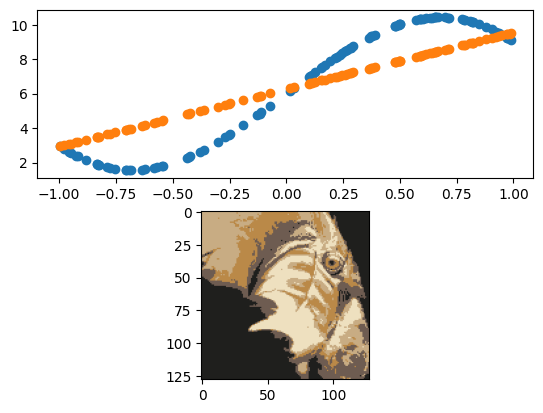

In [ ]:
main()

#Report

#**Problem 1**

1. The picture below shows 3 graphs: (x_train, y_train), (x_train, y_train) bounded by (x_test, y_test)'s plot, and (x_test, y_test). I wanted to see how I should expect the model I develop from the training data to fit the test data. If they're different relationships, then they wouldn't fit well.

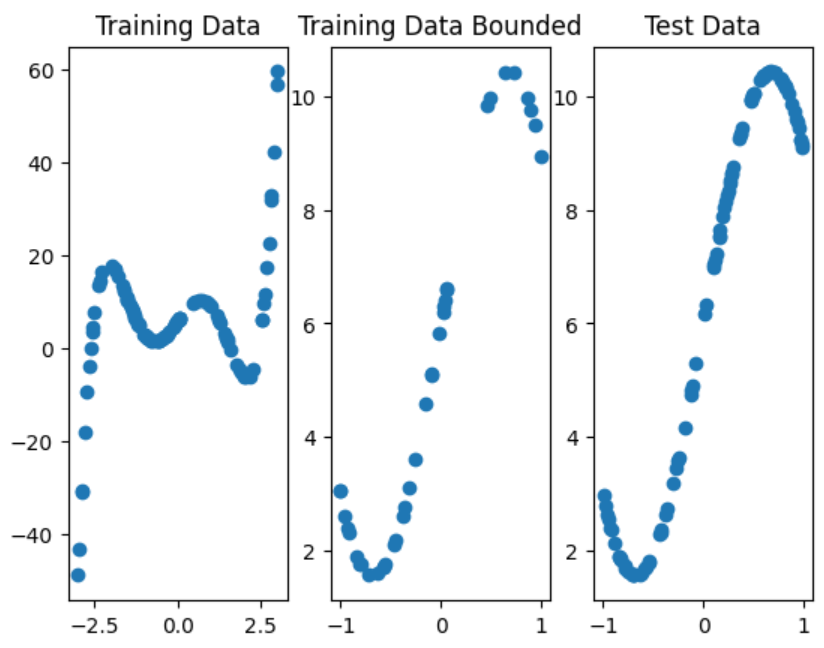

2. The relationship in the training and test data is not linear and we will need feature engineering to fit the data better. We can do this with basis functions! I decided to do a series of polynomial basis functions whose exponents increase (x^0 + x^1 + x^2...).



*   The thought process behind the code was to keep it simple and scalable which is why I went with polynomial basis functions. I can easily set a global variable to change the number of basis functions and weights we'll have.
* Batch gradient descent was used so I could repeat the function multiple times to make sure they always converged to the same value. In the early stages of coding, this was monumental in helping as my values were never converging.
* Learning rate is a function based on how many weights we had. I found that a learning rate too high either made the weights rise too quickly or made them bounce between positive and negative. They never converged if this happened. However, more weights required a lower learning rate and having to constantly change the learning rate is time consuming. Making it a function of the number of weights allows for constant changing without manually doing it.
*   The flow of the code is:
  1. Read in the training and test data.
  2. Use a uniform distribution to initialize weights.
  3. Repeat gradient descent updating until we converge.
  4. Find the MSE.
  5. Plot the model we found against the training data.






*   The equation I found was: y = 6.25535098 + 3.30820842 * x - 0.02086862 * x^2
*   I tried 2, 3, and 4 weights. Anything higher would cause an overflow in the error calculation. Out of the 3, 2 and 3 had the least MSE (with .02 of each other). I decided 3 would be the best as it has the lower MSE and has non-linearity. The non-linearity would help fit future data better.
*  Below are screenshots of running linear regression with 2, 3, and 4 weights. They contain the model and MSE against the test data.



2:
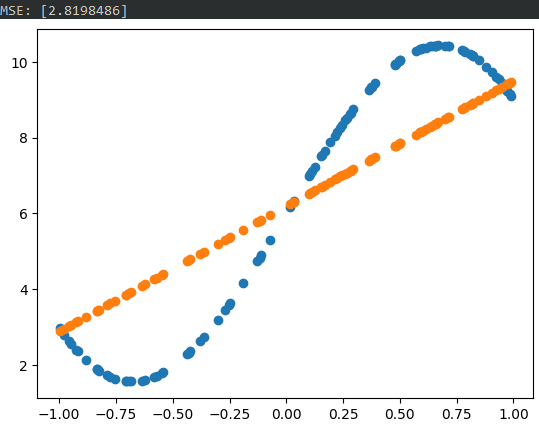

3:
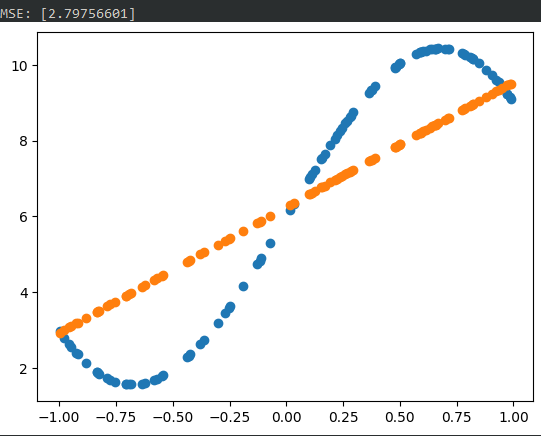

4:
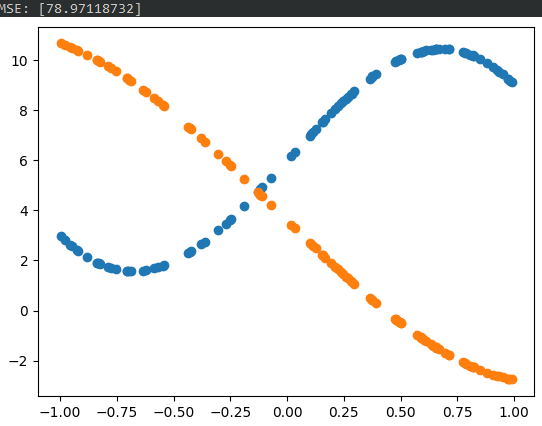

# **Problem 2**


*Conditional Probabilities*


*   All of the conditional probabilities are the normal distribution. I originally had a mix between continuous and discrete probabilities, but after the age of house feature had values from the test data that were not in the training data, I decided to convert all of the variables to conditional probabilities since all of them could have values outside the ones in the training data. You could include a probability for ones that don't show up, but since we're supposed to hard code them, I decided against it. Having a mix also included weird situations where the normal distribution returned values greater than 1, causing it to influence the MAP rule greatly.

* Local Price:

> * Local Price is a continuous value, meaning we'll have the probability modeled by the normal distribution. To make this, we'll need the mean and standard deviation for local price given each construction type.
> * P(Local Price | Apartment): We only take into account the values in apartment to calculate the mean and standard deviation. We also use sample standard deviation as we don't have every possible value in the population.
>>* μ = (4.9176 + 4.5573 + 5.0597 + 14.4598 + 5.05 + 8.2464 + 9.0384) / 7 = 7.332743
>>* σ = sqrt(((4.9176 - 7.332743)^2 + (4.5573 - 7.332643)^2 + (5.0597 - 7.332743)^2 + (14.4598 - 7.332743)^2 + (5.05 - 7.332743)^2 + (8.2464 - 7.332743)^2 + (9.0384 - 7.332743)^2)/ (7 - 1)) = 3.615997
>* Repeating this for Condo and House we get:
>*P(Local Price | Condo): Only include values from Condo into the equation
>> * μ = (4.5429 + 3.891 + 5.898 + 16.4202 + 5.9592 + 7.7841) / 6 = 7.4159
>>* σ = sqrt(((4.5429 - 7.4159)^2 + (3.891 - 7.4159)^2 + (5.898 - 7.4159)^2 + (16.4202 - 7.4159)^2 + (5.9592 - 7.4159)^2 + (7.7841 - 7.4159)^2)/ (6 - 1)) = 4.611248
>* P(Local Price | House): Only include values from House into the equation
>> * μ = (5.0208 + 5.6039 + 5.8282 + 5.3003 + 6.2712 + 5.6039 + 6.6969) / 7 = 5.76074
>>* σ = sqrt(((5.0208 - 5.76074)^2 + (5.6039 - 5.76074)^2 + (5.8282 - 5.76074)^2 + (5.3003 - 5.76074)^2 + (6.2712 - 5.76074)^2 + (5.6039 - 5.76074)^2 + (6.6969 - 5.76074)^2)/ (7 - 1)) = 0.57012

* Bathrooms:

> * Bathrooms is another continuous values, meaning we can have another normal distribution. We will again need the mean and standard deviation for bathrooms given each construction type. The calculations for this and all following probabilities are the same process as above. Find the mean and standard deviation for the feature given the class. Mean will be calculated by the sum of the values divided by the number of values. Standard deviation will be sample standard deviation.
>*P(Bathrooms | Apartment):
>> * μ = 1.285714
>> * σ = 0.566947
>*P(Bathrooms | Condo):
>> * μ = 1.33333
>> * σ = 0.60553
>*P(Bathrooms | House):
>> * μ = 1.071429
>> * σ = 0.18898

* Land Area:

> * P(Land Area | Apartment):
>> * μ = 6.10386
>> * σ = 3.25851
> * P(Land Area | Condo):
>> * μ = 6.024667
>> * σ = 2.544777
> * P(Land Area | House):
>> * μ = 6.6309
>> * σ = 2.24897

* Living Area:

> * P(Living Area | Apartment):
>> * μ = 1.505
>> * σ = 0.7041
> * P(Living Area | Condo):
>> * μ = 1.55333
>> * σ = 0.92344
> * P(Living Area | House):
>> * μ = 1.391714
>> * σ = 0.212924

* Number of Garages:

> * P(Number of Garages | Apartment):
>> * μ = 1.214286
>> * σ = 0.698638
> * P(Number of Garages | Condo):
>> * μ = 1.333333
>> * σ = 0.516398
> * P(Number of Garages | House):
>> * μ = 1.07143
>> * σ = 0.838082

* Number of Rooms:

> * P(Number of Rooms | Apartment):
>> * μ = 6.857143
>> * σ = 1.345185
> * P(Number of Rooms | Condo):
>> * μ = 6.833333
>> * σ = 1.602082
> * P(Number of Rooms | House):
>> * μ = 6.142857
>> * σ = 0.690065

* Number of Bedrooms:

> * P(Number of Bedrooms | Apartment):
>> * μ = 3.428571
>> * σ = 0.9759
> * P(Number of Bedrooms | Condo):
>> * μ = 3.333333
>> * σ = 0.8164966
> * P(Number of Bedrooms | House):
>> * μ = 3.0
>> * σ = 0.57735

* Number of Bedrooms:

> * P(Number of Bedrooms | Apartment):
>> * μ = 3.428571
>> * σ = 0.9759
> * P(Number of Bedrooms | Condo):
>> * μ = 3.333333
>> * σ = 0.8164966
> * P(Number of Bedrooms | House):
>> * μ = 3.0
>> * σ = 0.57735

* Age of Home:

> * P(Age of Home | Apartment):
>> * μ = 38.71429
>> * σ = 14.68235
> * P(Age of Home | Condo):
>> * μ = 39.66667
>> * σ = 13.9523
> * P(Age of Home | House):
>> * μ = 34.28571
>> * σ = 12.72418

* Construction Type:

> * This probability is different from the rest. Since this is our target, we only need to calculate it by doing #/total. This gives us the following probabilities
>> * P(Apartment): 7/20
>> * P(Condo): 6/20
>> * P(House): 7/20

*Performance Analysis*

* I was unsure of how to convert the binary classification of the confusion matrix and ended up deciding on a correct guess and incorrect guess being True Positive and False Positive respectively. Another option would be to use a One vs All or One vs One confusion matrix for each class, but there are not enough values to truly fill them out.
* Since we can only have True Positive and False Positive, the relevant measures would be accuracy, misclassification rate, and precision. Recall is irrelevant as there can be no False Negative.
* In this case, accuracy and precision are the same. Misclassification Rate is 1 - accuracy. We can analyze any of them to analyze all of them. With accuracy/precision, we'd want to maximize the value. Maximizing accuracy minimizes misclassification rate.
* I tried two methods: mixture between continuous and discrete probabilities and only continuous probabilities.
* First was the mixture. As explained before, the normal distribution was returning values that are above 1, influencing the MAP greatly. After running the naive bayes with this method, I only got 1/5 test cases correct. Since I can't go with only discrete values (as some features have to be continuous) and the possibility of values outside the training data, I decided to go only continuous probabilities.
* With continuous probabilities, our accuracy was 2/5. Not great, but this could be due to the low variance in some of the features between classes and a low sample size.

# **Problem 3**

* When choosing a k value for images, we need to strike a nice balance between visual fidelity and execution time. As visual fidelity increases (k increasing), our execution time increases exponentially.
* Images below show the result of running the k means for k = 2, 4, 8, 16, and 32.
* After experimenting, our bird starts to pop out with a k value between 8 and 16 as the accenting blues and oranges start to show up in the beak. Values past 16 start to take much longer for little payoff except more differences between blues.
> * When testing, k = 16 took about 1 minute while k = 32 took 2 minutes.
* For larger images, values between 4-8 would also be useful as the larger images would take longer to compute.


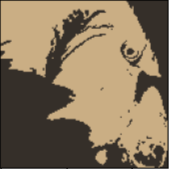
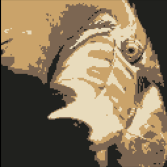
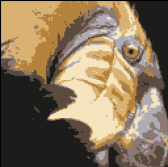
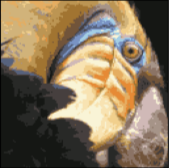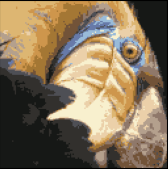